# Baseline优化

## 导入库并配置环境

In [1]:
import os, codecs
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

# %pylab inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

from matplotlib import font_manager as fm, rcParams
import matplotlib.pyplot as plt
import seaborn as sns

# 弃用，改为geopandas
# import geohash
# from geopy.distance import geodesic
import geopandas as gpd
from shapely import geometry

import hnswlib

In [2]:
PATH = './数据/'
plt.style.use('Solarize_Light2')

## 读取数据集
导入围栏数据（可得到区域面积、区域中心）、订单数据（锁的开/闭作为流出/入）、轨迹数据（同订单）

- 围栏数据

In [3]:
def bike_fence_format(s):
    # 将FENCE_LOC字段由五个列表合并为一个array
    s = s.replace('[', '').replace(']', '').split(',')
    s = np.array(s).astype(float).reshape(5, -1)
    return s

bike_fence = pd.read_csv(PATH + 'gxdc_tcd.csv')
bike_fence['FENCE_LOC'] = bike_fence['FENCE_LOC'].apply(bike_fence_format)
bike_fence.head(3)

,FENCE_ID,FENCE_LOC
0,长乐路0_L_A17001,"[[118.103198, 24.527338], [118.103224, 24.5273..."
1,长乐路0_L_A17002,"[[118.103171, 24.527303], [118.103198, 24.5273..."
2,长乐路0_L_A17003,"[[118.103231, 24.527386], [118.103257, 24.5274..."


- 订单数据

In [3]:
bike_order = pd.read_csv(PATH + 'gxdc_dd.csv')
bike_order = bike_order.sort_values(['BICYCLE_ID', 'UPDATE_TIME']).reset_index(drop=True)
bike_order.head(3)

,BICYCLE_ID,LATITUDE,LONGITUDE,LOCK_STATUS,UPDATE_TIME
0,0000ff105fd5f9099b866bccd157dc50,24.521156,118.140385,0,2020/12/21 6:32:48
1,0000ff105fd5f9099b866bccd157dc50,24.496578,118.142543,1,2020/12/21 6:50:18
2,0000ff105fd5f9099b866bccd157dc50,24.496582,118.142612,0,2020/12/21 8:23:32


- 轨迹数据

**注意：**ID与订单数据不匹配

In [5]:
bike_track1 = pd.read_csv(PATH + 'gxdc_gj20201221.csv')
bike_track2 = pd.read_csv(PATH + 'gxdc_gj20201222.csv')
bike_track3 = pd.read_csv(PATH + 'gxdc_gj20201223.csv')
bike_track4 = pd.read_csv(PATH + 'gxdc_gj20201224.csv')
bike_track5 = pd.read_csv(PATH + 'gxdc_gj20201225.csv')

bike_track = pd.concat([bike_track1, bike_track2, bike_track3, bike_track4, bike_track5]).reset_index(drop=True)
bike_track.head(3)

,BICYCLE_ID,LOCATING_TIME,LATITUDE,LONGITUDE,source,LOCATING_TIME1,date,day,time,hour
0,efdf62549732f4d75fb911dccffc044f,2020-12-21 06:00:12,24.521047,118.161504,CSXZGLZFJ,2020-12-21 06:00:12,2020-12-21,21,06:00:12,6
1,efdf62549732f4d75fb911dccffc044f,2020-12-21 06:00:27,24.520763,118.161702,CSXZGLZFJ,2020-12-21 06:00:27,2020-12-21,21,06:00:27,6
2,efdf62549732f4d75fb911dccffc044f,2020-12-21 06:00:42,24.520385,118.162053,CSXZGLZFJ,2020-12-21 06:00:42,2020-12-21,21,06:00:42,6


In [9]:
# 释放内存
del bike_track1
del bike_track2
del bike_track3
del bike_track4
del bike_track5

## 数据处理

### 缺失值处理
无缺失值

In [41]:
bike_fence.isnull().sum(axis=0)

FENCE_ID     0
FENCE_LOC    0
dtype: int64

In [42]:
bike_order.isnull().sum(axis=0)

BICYCLE_ID     0
LATITUDE       0
LONGITUDE      0
LOCK_STATUS    0
UPDATE_TIME    0
dtype: int64

In [43]:
bike_track.isnull().sum(axis=0)

BICYCLE_ID        0
LOCATING_TIME     0
LATITUDE          0
LONGITUDE         0
source            0
LOCATING_TIME1    0
date              0
day               0
time              0
hour              0
dtype: int64

### 字段调整

- 围栏数据

In [21]:
def loc_geo(item):
    return geometry.Polygon([(x,y) for x,y in item[:-1]])

bike_fence['LOC_GEO'] = bike_fence['FENCE_LOC'].apply(loc_geo)

In [29]:
bike_fence = gpd.GeoDataFrame(bike_fence,geometry='LOC_GEO')
del bike_fence['FENCE_LOC']
bike_fence.head(3)

,FENCE_ID,LOC_GEO
0,长乐路0_L_A17001,"POLYGON ((118.10320 24.52734, 118.10322 24.527..."
1,长乐路0_L_A17002,"POLYGON ((118.10317 24.52730, 118.10320 24.527..."
2,长乐路0_L_A17003,"POLYGON ((118.10323 24.52739, 118.10326 24.527..."


- 订单数据

In [4]:
# 坐标 Time 11.6s
bike_order = gpd.GeoDataFrame(bike_order, geometry=gpd.points_from_xy(bike_order.LONGITUDE, bike_order.LATITUDE))
del bike_order['LONGITUDE']
del bike_order['LATITUDE']

In [9]:
# 时间 Time 1.07s
bike_order['UPDATE_TIME'] = pd.to_datetime(bike_order['UPDATE_TIME'])

bike_order['day'] = bike_order['UPDATE_TIME'].dt.day.apply(str)
bike_order['hour'] = bike_order['UPDATE_TIME'].dt.hour.apply(str).str.pad(width=2,side='left',fillchar='0')
bike_order['min'] = bike_order['UPDATE_TIME'].dt.minute.apply(str).str.pad(width=2,side='left',fillchar='0')

bike_order['day+hour+min'] = bike_order['day'] + bike_order['hour'] + bike_order['min']
bike_order['day+hour'] = bike_order['day+hour+min'].apply(lambda x:x[:4])
bike_order['hour+min'] = bike_order['day+hour+min'].apply(lambda x:x[-4:])

del bike_order['UPDATE_TIME']
bike_order.head(3)

,BICYCLE_ID,LOCK_STATUS,geometry,day,hour,min,day+hour+min,day+hour,hour+min
0,0000ff105fd5f9099b866bccd157dc50,0,POINT (118.14039 24.52116),21,06,32,210632,2106,0632
1,0000ff105fd5f9099b866bccd157dc50,1,POINT (118.14254 24.49658),21,06,50,210650,2106,0650
2,0000ff105fd5f9099b866bccd157dc50,0,POINT (118.14261 24.49658),21,08,23,210823,2108,0823


- 轨迹数据

In [16]:
# source
del bike_track['source'] # 全部相同，删去

In [17]:
# LOCATING_TIME1
(bike_track['LOCATING_TIME'] != bike_track['LOCATING_TIME1']).sum() # 0
del bike_track['LOCATING_TIME1']

In [18]:
# time
del bike_track['time']

In [19]:
# date
(bike_track['day'] != pd.to_datetime(bike_track['date']).dt.day).sum() # 0
del bike_track['date']

In [20]:
# 坐标 Time 4m02s
bike_track = gpd.GeoDataFrame(bike_track, geometry=gpd.points_from_xy(bike_track.LONGITUDE, bike_track.LATITUDE))

del bike_track['LONGITUDE']
del bike_track['LATITUDE']

bike_track.head(3)

,BICYCLE_ID,LOCATING_TIME,day,hour,geometry
0,efdf62549732f4d75fb911dccffc044f,2020-12-21 06:00:12,21,6,POINT (118.16150 24.52105)
1,efdf62549732f4d75fb911dccffc044f,2020-12-21 06:00:27,21,6,POINT (118.16170 24.52076)
2,efdf62549732f4d75fb911dccffc044f,2020-12-21 06:00:42,21,6,POINT (118.16205 24.52038)


In [26]:
# 时间 Time 21.8s
bike_track['LOCATING_TIME'] = pd.to_datetime(bike_track['LOCATING_TIME'])

bike_track['day'] = bike_track['LOCATING_TIME'].dt.day.apply(str)
bike_track['hour'] = bike_track['LOCATING_TIME'].dt.hour.apply(str).str.pad(width=2,side='left',fillchar='0')
bike_track['min'] = bike_track['LOCATING_TIME'].dt.minute.apply(str).str.pad(width=2,side='left',fillchar='0')

bike_track['day+hour+min'] = bike_track['day'] +bike_track['hour'] + bike_track['min']
# bike_track['day+hour'] = bike_track['day+hour+min'].apply(lambda x:x[:4])
# bike_track['hour+min'] = bike_track['day+hour+min'].apply(lambda x:x[-4:])

bike_track.head(3)

,BICYCLE_ID,LOCATING_TIME,day,hour,geometry,min,day+hour+min
0,efdf62549732f4d75fb911dccffc044f,2020-12-21 06:00:12,21,06,POINT (118.16150 24.52105),00,210600
1,efdf62549732f4d75fb911dccffc044f,2020-12-21 06:00:27,21,06,POINT (118.16170 24.52076),00,210600
2,efdf62549732f4d75fb911dccffc044f,2020-12-21 06:00:42,21,06,POINT (118.16205 24.52038),00,210600


### 数据筛选

- 仅取在时段在7-9直接的数据

In [10]:
# bike_order
bike_order = bike_order[(bike_order.hour>='07')&(bike_order.hour<='09')].reset_index(drop=True)
# bike_track
bike_track = bike_track[(bike_track.hour>='07')&(bike_track.hour<='09')].reset_index(drop=True)

### 数据保存

In [31]:
# Time 1.81s
bike_fence.to_file(PATH+'bike_fence.json' ,driver='GeoJSON', encoding='utf-8')
# Time 53.9s
bike_order.to_file(PATH+'bike_order.json' ,driver='GeoJSON', encoding='utf-8')
# Time 23m18s
bike_track.to_file(PATH+'bike_track.json' ,driver='GeoJSON', encoding='utf-8')

In [39]:
del bike_fence
del bike_order
del bike_track

NameError: name 'bike_track' is not defined

## 数据初步分析

- 读取处理后的数据

In [32]:
# Time <1s
bike_fence = gpd.read_file(PATH+'bike_fence.json')
bike_fence.head(3)

,FENCE_ID,geometry
0,长乐路0_L_A17001,"POLYGON ((118.10320 24.52734, 118.10322 24.527..."
1,长乐路0_L_A17002,"POLYGON ((118.10317 24.52730, 118.10320 24.527..."
2,长乐路0_L_A17003,"POLYGON ((118.10323 24.52739, 118.10326 24.527..."


In [15]:
# Time 32s
bike_order = gpd.read_file(PATH+'bike_order.json')
bike_order.head(3)

,BICYCLE_ID,LOCK_STATUS,day,hour,min,day+hour+min,day+hour,hour+min,geometry
0,0000ff105fd5f9099b866bccd157dc50,0,21,08,23,210823,2108,0823,POINT (118.14261 24.49658)
1,0000ff105fd5f9099b866bccd157dc50,1,21,08,44,210844,2108,0844,POINT (118.16750 24.48135)
2,0000ff105fd5f9099b866bccd157dc50,0,22,08,00,220800,2208,0800,POINT (118.15522 24.50961)


In [162]:
# Time 
bike_track = gpd.read_file(PATH+'bike_track.json')
bike_track.head(3)

,BICYCLE_ID,LOCATING_TIME,LATITUDE,LONGITUDE,day,hour,min,day+hour+min,day+hour,hour+min
0,d703dde34bd7a027b7ed37de73ce9fa7,2020-12-21 07:00:10,24.491634,118.106267,21,7,0,210700,2107,700
1,d703dde34bd7a027b7ed37de73ce9fa7,2020-12-21 07:00:25,24.491640,118.106298,21,7,0,210700,2107,700
2,d703dde34bd7a027b7ed37de73ce9fa7,2020-12-21 07:00:40,24.491642,118.106305,21,7,0,210700,2107,700


### 单车使用情况[未做]
   有些单车的使用情况异常多，很可能是异常数据，需要考察

- 订单数据

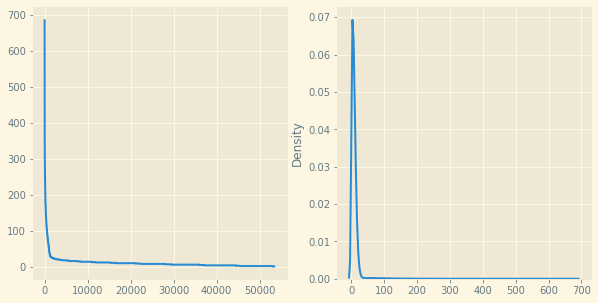

In [8]:
orderID_count = bike_order.groupby(by='BICYCLE_ID').count()['min']
orderID_count_val = orderID_count.sort_values(ascending=False).values

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.plot(orderID_count_val)
plt.subplot(1,2,2); sns.kdeplot(orderID_count_val)
plt.show()

In [38]:
orderID_count_m40 = orderID_count[orderID_count>=40].sort_values(ascending=False)
bike_order[bike_order['BICYCLE_ID'] == orderID_count_m40.idxmax()].head(3)

,BICYCLE_ID,LATITUDE,LONGITUDE,LOCK_STATUS,day,hour,min
53606,1677a23507c85c2e90f7d6f7fb30d07e,24.486072,118.163798,0,21,7,44
53607,1677a23507c85c2e90f7d6f7fb30d07e,24.484676,118.171765,1,21,7,53
53608,1677a23507c85c2e90f7d6f7fb30d07e,24.485426,118.171097,0,21,7,57


- 轨迹数据

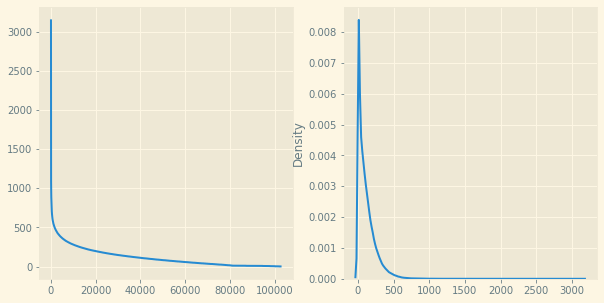

In [39]:
trackID_count = bike_track.groupby(by='BICYCLE_ID').count()['min']
trackID_count_val = trackID_count.sort_values(ascending=False).values

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.plot(trackID_count_val)
plt.subplot(1,2,2); sns.kdeplot(trackID_count_val)
plt.show()

In [40]:
trackID_count_m500 = trackID_count[trackID_count>500].sort_values(ascending=False)
bike_track[bike_track['BICYCLE_ID'] == trackID_count_m500.idxmax()].head(3)

,BICYCLE_ID,LATITUDE,LONGITUDE,day,hour,min
1026097,1f14a3dfdcd045f8d340482751c9bfba,24.471142,117.984211,21,6,0
1026098,1f14a3dfdcd045f8d340482751c9bfba,24.471142,117.984211,21,6,0
1026099,1f14a3dfdcd045f8d340482751c9bfba,24.471142,117.984211,21,6,0


### 地理坐标可视化[未做]
查看围栏区域、单车轨迹

- 围栏

- 轨迹

### 时间-单车使用可视化[未做]

### 其他内容...

## 特征工程

### 围栏数据

- 面积:FENCE_AREA

In [17]:
bike_fence['FENCE_AREA'] = bike_fence['LOC_GEO'].area
bike_fence.head(3)

NameError: name 'bike_fence' is not defined

- 路名:ROAD_NAME

In [36]:
bike_fence['ROAD_NAME'] = bike_fence['FENCE_ID'].apply(lambda x:x.split('_')[0])
bike_fence.head(3)

,FENCE_ID,FENCE_LOC,LOC_GEO,FENCE_AREA,FENCE_CENTER,ROAD_NAME
0,长乐路0_L_A17001,"[[118.103198, 24.527338], [118.103224, 24.5273...","POLYGON ((118.10320 24.52734, 118.10322 24.527...",5.880000e-10,POINT (118.10322 24.52735),长乐路0
1,长乐路0_L_A17002,"[[118.103171, 24.527303], [118.103198, 24.5273...","POLYGON ((118.10317 24.52730, 118.10320 24.527...",5.740000e-10,POINT (118.10319 24.52732),长乐路0
2,长乐路0_L_A17003,"[[118.103231, 24.527386], [118.103257, 24.5274...","POLYGON ((118.10323 24.52739, 118.10326 24.527...",6.630000e-10,POINT (118.10325 24.52740),长乐路0


- 路段围栏数:ROAD_COUNT

In [37]:
# 得到字典 {路名:围栏个数}
road_count_series = bike_fence.groupby(by='ROAD_NAME').count()['FENCE_ID']
road_count_dic = {index:value for index,value in road_count_series.items()}
# 映射到数据表
bike_fence['ROAD_COUNT'] = bike_fence['ROAD_NAME'].map(road_count_dic)
bike_fence.head(3)

,FENCE_ID,FENCE_LOC,LOC_GEO,FENCE_AREA,FENCE_CENTER,ROAD_NAME,ROAD_COUNT
0,长乐路0_L_A17001,"[[118.103198, 24.527338], [118.103224, 24.5273...","POLYGON ((118.10320 24.52734, 118.10322 24.527...",5.880000e-10,POINT (118.10322 24.52735),长乐路0,70
1,长乐路0_L_A17002,"[[118.103171, 24.527303], [118.103198, 24.5273...","POLYGON ((118.10317 24.52730, 118.10320 24.527...",5.740000e-10,POINT (118.10319 24.52732),长乐路0,70
2,长乐路0_L_A17003,"[[118.103231, 24.527386], [118.103257, 24.5274...","POLYGON ((118.10323 24.52739, 118.10326 24.527...",6.630000e-10,POINT (118.10325 24.52740),长乐路0,70


- 路段围栏总面积:AREA_SUM

In [38]:
# 得到字典 {路名:围栏总面积}
area_sum_series = bike_fence.groupby(by='ROAD_NAME').sum()['FENCE_AREA']
area_sum_dic = {index:value for index,value in area_sum_series.items()}
# 映射到数据表
bike_fence['AREA_SUM'] = bike_fence['ROAD_NAME'].map(area_sum_dic)
bike_fence.head(3)

,FENCE_ID,FENCE_LOC,LOC_GEO,FENCE_AREA,FENCE_CENTER,ROAD_NAME,ROAD_COUNT,AREA_SUM
0,长乐路0_L_A17001,"[[118.103198, 24.527338], [118.103224, 24.5273...","POLYGON ((118.10320 24.52734, 118.10322 24.527...",5.880000e-10,POINT (118.10322 24.52735),长乐路0,70,5.861268e-08
1,长乐路0_L_A17002,"[[118.103171, 24.527303], [118.103198, 24.5273...","POLYGON ((118.10317 24.52730, 118.10320 24.527...",5.740000e-10,POINT (118.10319 24.52732),长乐路0,70,5.861268e-08
2,长乐路0_L_A17003,"[[118.103231, 24.527386], [118.103257, 24.5274...","POLYGON ((118.10323 24.52739, 118.10326 24.527...",6.630000e-10,POINT (118.10325 24.52740),长乐路0,70,5.861268e-08


- 路段围栏面积平均数:AREA_MEAN

In [40]:
bike_fence['AREA_MEAN'] = bike_fence['AREA_SUM']/bike_fence['ROAD_COUNT']
bike_fence.head(3)

,FENCE_ID,FENCE_LOC,LOC_GEO,FENCE_AREA,FENCE_CENTER,ROAD_NAME,ROAD_COUNT,AREA_SUM,AREA_MEAN
0,长乐路0_L_A17001,"[[118.103198, 24.527338], [118.103224, 24.5273...","POLYGON ((118.10320 24.52734, 118.10322 24.527...",5.880000e-10,POINT (118.10322 24.52735),长乐路0,70,5.861268e-08,8.373240e-10
1,长乐路0_L_A17002,"[[118.103171, 24.527303], [118.103198, 24.5273...","POLYGON ((118.10317 24.52730, 118.10320 24.527...",5.740000e-10,POINT (118.10319 24.52732),长乐路0,70,5.861268e-08,8.373240e-10
2,长乐路0_L_A17003,"[[118.103231, 24.527386], [118.103257, 24.5274...","POLYGON ((118.10323 24.52739, 118.10326 24.527...",6.630000e-10,POINT (118.10325 24.52740),长乐路0,70,5.861268e-08,8.373240e-10


- 路段围栏面积是否大于平均值:AREA_FLAG

In [41]:
bike_fence['AREA_FLAG'] = bike_fence['FENCE_AREA']>=bike_fence['AREA_MEAN']
bike_fence.head(3)

,FENCE_ID,FENCE_LOC,LOC_GEO,FENCE_AREA,FENCE_CENTER,ROAD_NAME,ROAD_COUNT,AREA_SUM,AREA_MEAN,AREA_FLAG
0,长乐路0_L_A17001,"[[118.103198, 24.527338], [118.103224, 24.5273...","POLYGON ((118.10320 24.52734, 118.10322 24.527...",5.880000e-10,POINT (118.10322 24.52735),长乐路0,70,5.861268e-08,8.373240e-10,False
1,长乐路0_L_A17002,"[[118.103171, 24.527303], [118.103198, 24.5273...","POLYGON ((118.10317 24.52730, 118.10320 24.527...",5.740000e-10,POINT (118.10319 24.52732),长乐路0,70,5.861268e-08,8.373240e-10,False
2,长乐路0_L_A17003,"[[118.103231, 24.527386], [118.103257, 24.5274...","POLYGON ((118.10323 24.52739, 118.10326 24.527...",6.630000e-10,POINT (118.10325 24.52740),长乐路0,70,5.861268e-08,8.373240e-10,False


- 围栏区域中心:FENCE_CENTER

In [33]:
bike_fence['FENCE_CENTER'] = bike_fence['LOC_GEO'].centroid
bike_fence.head(3)

,FENCE_ID,FENCE_LOC,LOC_GEO,FENCE_AREA,FENCE_CENTER
0,长乐路0_L_A17001,"[[118.103198, 24.527338], [118.103224, 24.5273...","POLYGON ((118.10320 24.52734, 118.10322 24.527...",5.880000e-10,POINT (118.10322 24.52735)
1,长乐路0_L_A17002,"[[118.103171, 24.527303], [118.103198, 24.5273...","POLYGON ((118.10317 24.52730, 118.10320 24.527...",5.740000e-10,POINT (118.10319 24.52732)
2,长乐路0_L_A17003,"[[118.103231, 24.527386], [118.103257, 24.5274...","POLYGON ((118.10323 24.52739, 118.10326 24.527...",6.630000e-10,POINT (118.10325 24.52740)


### 订单数据

In [18]:
bike_order

,BICYCLE_ID,LOCK_STATUS,day,hour,min,day+hour+min,day+hour,hour+min,geometry
0,0000ff105fd5f9099b866bccd157dc50,0,21,08,23,210823,2108,0823,POINT (118.14261 24.49658)
1,0000ff105fd5f9099b866bccd157dc50,1,21,08,44,210844,2108,0844,POINT (118.16750 24.48135)
2,0000ff105fd5f9099b866bccd157dc50,0,22,08,00,220800,2208,0800,POINT (118.15522 24.50961)
3,0000ff105fd5f9099b866bccd157dc50,1,22,08,14,220814,2208,0814,POINT (118.14756 24.49480)
4,0000ff105fd5f9099b866bccd157dc50,0,22,08,19,220819,2208,0819,POINT (118.14753 24.49465)
...,...,...,...,...,...,...,...,...,...
542652,ffffa4a7c6cd6cda114fdb0e6f391038,0,21,08,42,210842,2108,0842,POINT (118.07065 24.46509)
542653,ffffa4a7c6cd6cda114fdb0e6f391038,1,21,08,47,210847,2108,0847,POINT (118.06741 24.46116)
542654,ffffa4a7c6cd6cda114fdb0e6f391038,0,24,08,10,240810,2408,0810,POINT (118.08938 24.48496)
542655,ffffa4a7c6cd6cda114fdb0e6f391038,1,24,08,26,240826,2408,0826,POINT (118.10565 24.47116)


- 坐标所属围栏位置:FENCE_ID

In [19]:
# 得到围栏 GeoSeries
bike_fence[['FENCE_ID','LOC_GEO']]

NameError: name 'bike_fence' is not defined

In [ ]:
def loc_fence(item):
    for ID,GeoLoc in bike_fence['FENCE_ID','LOC_GEO']:
        if GeoLoc.intersects(item):
            return ID
    else:
        return 'None'

bike_order['FENCE_ID'] = bike_order['geometry'].apply(loc_fence)

### 轨迹数据

### 特征工程数据保存

In [134]:
bike_fence.to_csv(PATH+'bike_fence_FE.csv' ,index=0)

In [210]:
gpdtmp = gpd.GeoSeries([geometry.Polygon([(x,y) for x,y in bike_fence['FENCE_LOC'][1][:-1]])])
gpdtmp= gpd.GeoDataFrame(gpdtmp)
gpdtmp

,0
0,"POLYGON ((118.10317 24.52730, 118.10320 24.527..."


In [224]:
gpd.sjoin(gpdtmp1,gpdtmp,op='within')

NameError: name 'PyGEOSSTRTreeIndex' is not defined

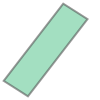

In [198]:
gpdtmp[0]

In [2]:
import geopandas as gpd

<AxesSubplot:>

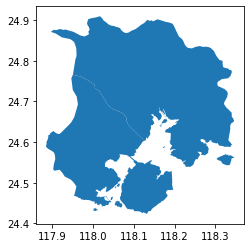

In [4]:
gdf = gpd.read_file(filename=r'D:\Python\Python Codes\数据可视化\shp,json,geojson,gpkg\gadm36_CHN_shp\gadm36_CHN_3.shp')
gdf = gdf[gdf['NL_NAME_2']=='厦门市']
gdf.plot()

In [249]:
gpd.__version__

'0.8.1'